## Ignition delay simulation of complete n-c10 RMG model

In [1]:
import sys
sys.path.append('/scratch/ajulu.c/anaconda3/envs/rmg_py3')

In [2]:
!which python
# !conda list rmg_py3

/scratch/ajulu.c/anaconda3/envs/rmg_py3/bin/python


In [3]:
import cantera as ct
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

ct.__version__

'2.4.0'

In [4]:
# from cantera import ck2cti

# ck2cti.main([
#     '--input=nc10_lowT/chemkin/chem.inp',
#     '--tran=nc10_lowT/chemkin/tran.dat',
#     '--output=nc10_lowT/chemkin/chem.cti',
#     '--permissive'])

In [5]:
gas = ct.Solution('nc10_lowT/chemkin/chem.cti')



**** WARNING ****
For species HOCHO(306), discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  -40.3604
	Value computed using high-temperature polynomial: -38.1678


In [6]:
print(len(gas.species()), len(gas.reactions()))

502 12474


In [7]:
sorted(gas.species_names)

['Ar',
 'C(279)',
 'C2(299)',
 'C2H(4)',
 'C2H2(280)',
 'C2H2O(965)',
 'C2H3(278)',
 'C2H3O(287)',
 'C2H3O(298)',
 'C2H3O(305)',
 'C2H4(11)',
 'C2H4(987)',
 'C2H4O(284)',
 'C2H4O(289)',
 'C2H4O(291)',
 'C2H5(277)',
 'C2H5O(285)',
 'C2H5O(290)',
 'C2H5O(302)',
 'C2H6(283)',
 'C2H6O(301)',
 'C2O(300)',
 'C3H5(350)',
 'C3H5O(326)',
 'C3H5O(333)',
 'C3H5O(387)',
 'C3H6(12)',
 'C3H6O(332)',
 'C4H7O(513)',
 'C4H7O(515)',
 'C4H7O(523)',
 'C4H8(443)',
 'C4H8O(519)',
 'C5H10(676)',
 'C5H11(673)',
 'C5H11(674)',
 'C6H12(996)',
 'C6H13(933)',
 'C7H15(931)',
 'C8H17(932)',
 'CH(3)',
 'CH2(269)',
 'CH2(271)',
 'CH2CO(276)',
 'CH2O(9)',
 'CH2OH(272)',
 'CH3(268)',
 'CH3CO(304)',
 'CH3O(273)',
 'CH3O2(282)',
 'CH3O2(312)',
 'CH3OH(270)',
 'CH3OO(275)',
 'CH4(10)',
 'CH4O2(281)',
 'CHCHO(294)',
 'CO(6)',
 'CO2(7)',
 'H(261)',
 'H2(13)',
 'H2CC(288)',
 'H2O(8)',
 'H2O2(265)',
 'HCCO(296)',
 'HCCOH(297)',
 'HCO(267)',
 'HCOH(274)',
 'HO2(264)',
 'HOCHO(306)',
 'HOCO(266)',
 'He(263)',
 'N2',
 'NC3H7(348

In [8]:
for species in gas.species():
    if species.composition == {'C':10,'H':22}:
        print(species.name)

nC10H22(1)


In [9]:
species_names = {
    'nc10':'nC10H22(1)',
    'Ar':'Ar',
    'N2':'N2',
    'O2':'O2(2)',
    'O':'O(5)',
    'C2H':'C2H(4)',
    'OH':'OH(262)',
    'H':'H(261)'
}

In [10]:
for s in species_names.values():
    assert s in gas.species_names, "{} not found".format(s)

In [11]:
gas.TP = 1000, 10e5
gas.set_equivalence_ratio(phi=1.0, fuel = species_names['nc10'], 
                          oxidizer = {species_names['O2']:0.21,
                                      species_names['N2']:0.79})
gas()


  gas:

       temperature            1000  K
          pressure           1e+06  Pa
           density         3.65228  kg/m^3
  mean mol. weight         30.3667  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.2319e+05        2.196e+07     J
   internal energy      4.4938e+05        1.365e+07     J
           entropy          7490.6        2.275e+05     J/K
    Gibbs function     -6.7675e+06       -2.055e+08     J
 heat capacity c_p          1313.4        3.988e+04     J/K
 heat capacity c_v          1039.6        3.157e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2        0.77944         0.719038         -22.8116
        nC10H22(1)      0.0133673        0.0626331         -118.441
             O2(2)       0.207193         0.218329         -25.8365
     [ +499 minor]          

In [12]:
# def get_mole_fractions(phi):
#     """
#     The paper comparison comes from Titova et al. doi:10.1134/S0010508211020018 
#     Kinetic Mechanisms of n_Decane Oxidation compared n-decane mechanisms to shock tube experiments of 
#     D.C. Horning PhD Thesis of High-temperature auto-ignition and thermal decomposition of hydrocarbons
#     0.2% nc10 in 3.1%O2/Ar mixture
#     """
    

#     fraction_nc10 = 0.002
#     fraction_O2 = 15.5 * fraction_nc10 / phi
#     fraction_Ar = 1 - (fraction_nc10 + fraction_O2)
    
#     X = {species_names['nc10']:fraction_nc10,
#         species_names['O2']:fraction_O2,
#         species_names['Ar']:fraction_Ar}
    
#     return X
# gas.X = get_mole_fractions(phi=1.0)
# gas()

In [58]:
a = np.array((-1, -4, 0, 3))
list(reversed(np.argsort(np.abs(a))))

[1, 3, 0, 2]

In [63]:
def get_sensitivities(gas, TPX, max_n=None):
    """
    Get sensitivity of OH with respect to k for the first max_n reactions.
    """
    gas.TPX = TPX
    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])

    # number of reactions to consider
    if max_n is None:
        n_sens = len(gas.reactions())
    else:
        n_sens = min(max_n, len(gas.reactions()))

    for i in range(n_sens):
        reactor.add_sensitivity_reaction(i)

    reactor_network.step()
    
    oh_sensitivities = np.zeros(n_sens)
    for i in range(n_sens):
        oh_sensitivities[i] = reactor_network.sensitivity(species_names['OH'], i)

    ranking = list(reversed(np.argsort(np.abs(oh_sensitivities))))

    print(f"Top 20 sensitivities (of the first {n_sens} considered)")
    for i, j in enumerate(ranking[:20]):
        print(i, j,
              reactor_network.sensitivity_parameter_name(j), 
              oh_sensitivities[j]
             )
    return oh_sensitivities
    
    
def get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=False, sensitivity=False):
    """
    A general function to find the igniton delay.
    Using C2H + O --> CH* as the indication of ignition
    
    gas is a cantera Solution object
    temperature in K
    pressure_bar is in bar
    mole_fractions is a dict
    
    sensitivity is Boolean, whether to run sensitivity analysis
    """
    gas.TPX = temperature, pressure_bar*1e5, mole_fractions

    reactor = ct.IdealGasReactor(gas)
    reactor_network = ct.ReactorNet([reactor])
    
    time = 0.0
    end_time = 20e-3
    
    times = []
    concentrations = []
    pressures = []
    temperatures = []

    # set the tolerances for the solution and for the sensitivity coefficients
    reactor_network.rtol = 1.0e-6
    reactor_network.atol = 1.0e-15
    reactor_network.rtol_sensitivity = 1.0e-6
    reactor_network.atol_sensitivity = 1.0e-6
            
    print_data = True
    sensitivity_done = False
    while time < end_time:
        time = reactor_network.time
        times.append(time)
        temperatures.append(reactor.T)
        pressures.append(reactor.thermo.P)
        concentrations.append(reactor.thermo.concentrations)
        
        # take a timestep
        # the size of the step will be determined by the ODE solver
        # depending on how quickly things are changing.
        reactor_network.step()
        
        # Some timestep:
        if sensitivity and not sensitivity_done:
            if reactor.T > temperature + 100: # do it when T has risen 100K above start point
                TPX_for_sensitivity = gas.TPX
                time_for_sensitivity = time
                sensitivity_done = True # just do it once
        
    print("Reached end time {0:.2f} ms in {1} steps".format(times[-1]*1e3, len(times)))
    # convert the lists into arrays
    concentrations = np.array(concentrations)
    times = np.array(times)
    pressures = np.array(pressures)
    temperatures = np.array(temperatures)

    if plot:
        plt.subplot(2,1,1)
        plt.plot(times*1e3, pressures/1e5)
        plt.ylabel("Pressure (bar)", color='b')
        ax2 = plt.gca().twinx()
        ax2.set_ylabel('Temperature (K)', color='r')
        ax2.plot(times*1e3, temperatures, 'r')
    # Using C2H + O --> CH* as the indication of ignition
    i_c2h = gas.species_index(species_names['C2H'])   
    i_o = gas.species_index(species_names['O'])
    excited_ch_generation = concentrations[:,i_o] * concentrations[:,i_c2h]
    if plot:
        plt.subplot(2,1,2)
        plt.plot(times*1e3, excited_ch_generation, 'g')
        plt.ylabel("CH* emission")
        plt.ylim(0,max(1e-13,1.1*max(excited_ch_generation)))
        plt.xlabel("Time (ms)")
        plt.tight_layout()
        plt.show()
    step_with_highest_ch_gen = excited_ch_generation.argmax()
        
    if step_with_highest_ch_gen > 1 and excited_ch_generation.max()>1e-20:
        ignition_time_ms = 1e3 * times[step_with_highest_ch_gen]
        print("At {0} K {1} bar, ignition delay time is {2} ms".format(temperature, pressure_bar, ignition_time_ms))
    else:
        print("At {0} K {1} bar, no ignition detected".format(temperature, pressure_bar))
        ignition_time_ms = np.infty
    
    print(f"Performing sensitivity at time {time_for_sensitivity/1000} ms at {gas.T} K, {gas.P} Pa")
    print()
    get_sensitivities(gas, TPX_for_sensitivity)
    
    return ignition_time_ms

In [64]:
# def get_ignition_delay_ar(temperature, pressure_bar, phi, plot=False):
#     """
#     The paper comparison comes from Titova et al. doi:10.1134/S0010508211020018 
#     Kinetic Mechanisms of n_Decane Oxidation compared n-decane mechanisms to shock tube experiments of 
#     D.C. Horning PhD Thesis of High-temperature auto-ignition and thermal decomposition of hydrocarbons
#     0.2% nc10 in 3.1%O2/Ar mixture.
#     Ignition delay time condition is at P = 1.2 - 1.3 atm between 1400 - 1550 K
#     """
    
#     gas.TP = temperature, pressure_bar*1e5
    
#     mole_fractions = get_mole_fractions(phi)
    
#     if plot:
#         gas()
        
#     time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot)

#     return time
    


In [61]:
def get_ignition_delay_n2(temperature, pressure_bar, phi, plot=False, sensitivity=False):
    """
    The paper comparison comes from Pfahl et al and Zhukov et al. --> DOI: 10.1016/j.combustflame.2007.09.006 
    Autoignition of n_Decane at high pressure and self-ignition of diesel relevant hydro-carbon-ar mixtures under 
    engine relevant conditions; compared n-decane mechanisms to shock tube experiments of Zhukov and Pfahl respectively. 
    nc10 in air mixtures between phi = [0.5 1.0 2.0] for pressures at 13 and 50 bar
    Ignition delay time condition is at P = 13 - 50 bar between 666 - 1450 K
    """
    
    gas.TP = temperature, pressure_bar*1e5
    
    gas.set_equivalence_ratio(phi=phi, fuel = species_names['nc10'], 
                              oxidizer = {species_names['O2']:0.21,
                                      species_names['N2']:0.79})
                              
    mole_fractions = gas.X
                              
    if plot:
        gas()
        
    time = get_ignition_delay(gas, temperature, pressure_bar, mole_fractions, plot=plot, sensitivity=sensitivity)

    return time
    


  gas:

       temperature         833.333  K
          pressure           5e+06  Pa
           density         21.9137  kg/m^3
  mean mol. weight         30.3667  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      5.0863e+05        1.545e+07     J
   internal energy      2.8046e+05        8.517e+06     J
           entropy          6815.4         2.07e+05     J/K
    Gibbs function     -5.1709e+06        -1.57e+08     J
 heat capacity c_p          1259.7        3.825e+04     J/K
 heat capacity c_v           985.9        2.994e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                N2        0.77944         0.719038         -20.7541
        nC10H22(1)      0.0133673        0.0626331         -117.026
             O2(2)       0.207193         0.218329          -23.754
     [ +499 minor]          

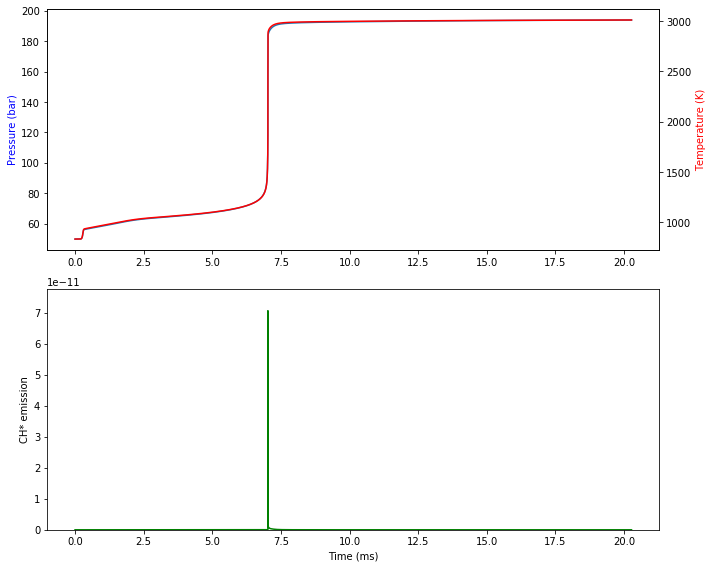

At 833.3333333333334 K 50 bar, ignition delay time is 7.025726476569674 ms
Performing sensitivity at time 3.3233272865759684e-07 ms at 3011.9365367736546 K, 19391117.962395184 Pa

Top 20 sensitivities
0 IdealGasReactor_19: OH(262) + nC10H22(1) <=> H2O(8) + R_3(16) -7.905097995861067e-05
Top 20 sensitivities
1 IdealGasReactor_19: CH2O(9) + OH(262) <=> H2O(8) + HCO(267) -4.231021988144947e-05
Top 20 sensitivities
2 IdealGasReactor_19: C3H6(12) + OH(262) <=> C3H5(350) + H2O(8) -2.780679906690051e-05
Top 20 sensitivities
3 IdealGasReactor_19: H2O2(265) (+M) <=> 2 OH(262) (+M) 2.594372530132362e-05
Top 20 sensitivities
4 IdealGasReactor_19: CH4O2(281) <=> CH3O(273) + OH(262) 2.2679545490280622e-05
Top 20 sensitivities
5 IdealGasReactor_19: C2H3O(287) + O2(2) <=> CH2O(9) + CO(6) + OH(262) 2.064823510002322e-05
Top 20 sensitivities
6 IdealGasReactor_19: OH(262) + S(193) <=> S(165) 1.7444263456874736e-05
Top 20 sensitivities
7 IdealGasReactor_19: S(5134) <=> OH(262) + S(8387) 1.591009464085692

In [62]:
get_ignition_delay_n2(1000/1.2, 50, 1, plot=True, sensitivity=True)
plt.rcParams['figure.figsize'] = [10, 8]

In [30]:
RMG_temperatures_dkm = 1000/np.linspace(0.65,1.5,15)
pressures_bar = [13, 50]
phi = 1.0

RMG_results_lowT = dict()

for P in pressures_bar:
    ignition_delay_times = np.zeros_like(RMG_temperatures_dkm)
    for i, T in enumerate(RMG_temperatures_dkm):
        ignition_delay_times[i] = get_ignition_delay_n2(T,P,phi)
    
    RMG_results_lowT[P] = ignition_delay_times 
    
    plt.semilogy(1000/RMG_temperatures_dkm, ignition_delay_times, 'o-', label='{0}'.format(P))


Reached end time 5.45 ms in 1789 steps
At 1538.4615384615383 K 13 bar, ignition delay time is 0.0163173580299722 ms
Reached end time 5.21 ms in 1979 steps
At 1407.035175879397 K 13 bar, ignition delay time is 0.06976625953598743 ms


KeyboardInterrupt: 

In [ ]:
import pickle 

with open('n-c10-dkm.pkl', 'wb') as fp:
    pickle.dump((RMG_temperatures_dkm, RMG_results[P]), fp)

In [ ]:
# exp_nc10 = """0.659295    0.122155
# 0.679932    0.180035
# 0.686702    0.232651
# 0.691658    0.282004
# 0.697209    0.309786
# 0.715798    0.457250
# """


# ign_times = []
# temps = []


# for x in exp_nc10.splitlines():
#     temp, time = x.split()
#     ign_times.append(float(time))
#     temps.append(float(temp))
# temps = np.array(temps)
# ign_times = np.array(ign_times)

In [18]:
# extracted values of experimental ignition delay times for iso-octane in air from Pfhal et al @ 13 bar 
# using the docstrings


exp_nc10_13 = """0.771216    0.0869649
0.809216    0.191947
0.830035    0.264515
0.938927    0.785369
0.987919    1.73243
1.07350     2.82456
1.09187     3.81030
1.07099     1.92002
1.16876     2.75052
1.19687     3.05735
1.25302     2.45962
1.30917     2.11029
1.37027     2.44420
1.43262     3.43364
"""

exp_nc10_50 = """1.05546   0.338838
1.06769   0.331359
1.12629   0.239352
1.13114   0.197372
1.18007   0.218828
1.20089   0.253762
1.23270   0.269920
1.31961   0.402551
1.37116   0.884630
1.43976   1.43915
1.52559   3.90651
"""

ign_times13 = []
temps13 = []

ign_times50 = []
temps50 = []


for x in exp_nc10_13.splitlines():
    temp, time = x.split()
    ign_times13.append(float(time))
    temps13.append(float(temp))
temps13 = np.array(temps13)
ign_times13 = np.array(ign_times13)


for y in exp_nc10_50.splitlines():
    temps, times = y.split()
    ign_times50.append(float(times))
    temps50.append(float(temps))
temps50 = np.array(temps50)
ign_times50 = np.array(ign_times50)
    

{13: array([6.85324752e-03, 2.16962320e-02, 6.57796258e-02, 1.79529562e-01,
       4.26156780e-01, 1.00022354e+00, 2.50911193e+00, 6.04111127e+00,
       1.17627818e+01, 1.61750297e+01, 1.76297174e+01, 1.92463501e+01,
       2.29037959e+01, 3.18226541e+01, 5.29549838e+01]), 50: array([2.98520586e-03, 8.56790147e-03, 2.30151260e-02, 5.47835967e-02,
       1.26545732e-01, 3.00279689e-01, 6.47916423e-01, 1.08295354e+00,
       1.42594751e+00, 1.80848351e+00, 2.36792301e+00, 3.31922425e+00,
       5.23884884e+00, 9.55989375e+00, 1.99184653e+01])}


<function matplotlib.pyplot.show(*args, **kw)>

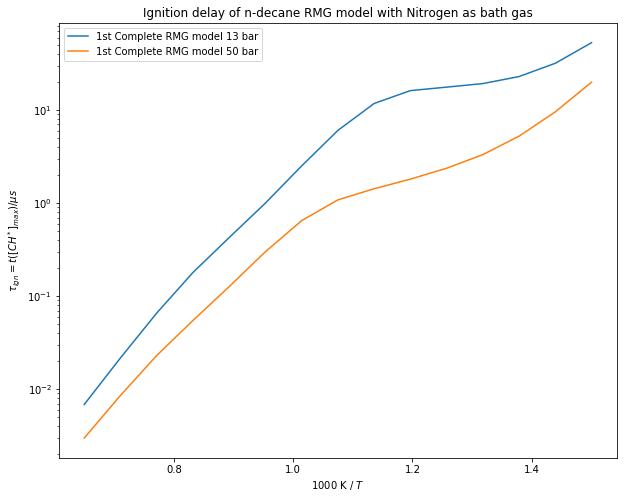

In [54]:
import pickle 


pickle_in = open('n-c10-dkm.pickle', 'rb')       
RMG_1_results = pickle.load(pickle_in)

print(RMG_1_results)

for key, val in RMG_1_results.items():
    plt.semilogy(1000/RMG_temperatures_dkm, val, '-', label= '1st Complete RMG model {} bar'.format(key))
    
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of n-decane RMG model with Nitrogen as bath gas')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

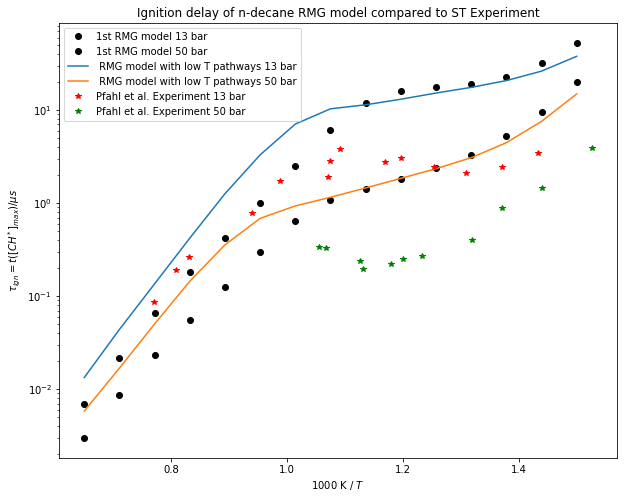

In [57]:


#plt.semilogy(temps, ign_times, 'g*', label='DC. Horning Experiment 1 atm')    


    
for key, val in RMG_1_results.items():
    plt.semilogy(1000/RMG_temperatures_dkm, val, 'ko', label= '1st RMG model {} bar'.format(key))
    


    
for P in pressures_bar:
    times = RMG_results_lowT[P]
    
    plt.semilogy(1000/RMG_temperatures_dkm,times,label=' RMG model with low T pathways {} bar'.format(P))    
    
    
    
plt.semilogy(temps13,ign_times13, 'r*', label='Pfahl et al. Experiment 13 bar')
plt.semilogy(temps50, ign_times50, 'g*', label='Pfahl et al. Experiment 50 bar')




plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of n-decane RMG model compared to ST Experiment')
plt.show

In [ ]:





# # #plt.semilogy(temps, ign_times, 'g*', label='DC. Horning Experiment 1 atm')

# plt.semilogy(1000/RMG_temperatures_dkm,times,label=' RMG model {} bar'.format(P))
# plt.legend(loc='best')
# plt.xlabel('1000 K / $T$')
# plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
# plt.rcParams['figure.figsize'] = [10, 8]
# plt.title('Ignition delay of n-decane detailed kinetic model compared to reduced model compared to ST experiment')
# plt.show


    


In [ ]:
# plt.semilogy(temps,ign_times, 'r*', label='DC Horning Experiment 1 atm')
# plt.semilogy(1000/RMG_temperatures, times, 'o-', label='RMG model {0} atm'.format(pressures_bar))
    
# plt.legend(loc='best')
# plt.xlabel("1000 K / temperature")
# #plt.xlim(0.6,0.8)
# plt.ylabel("Ignition delay time $\\tau$ (ms)")
# plt.title('RMG model of Ignition delay of n-Decane at $\phi$=1.0')
# plt.show()   
# plt.rcParams['figure.figsize'] = [10, 8]

<function matplotlib.pyplot.show(*args, **kw)>

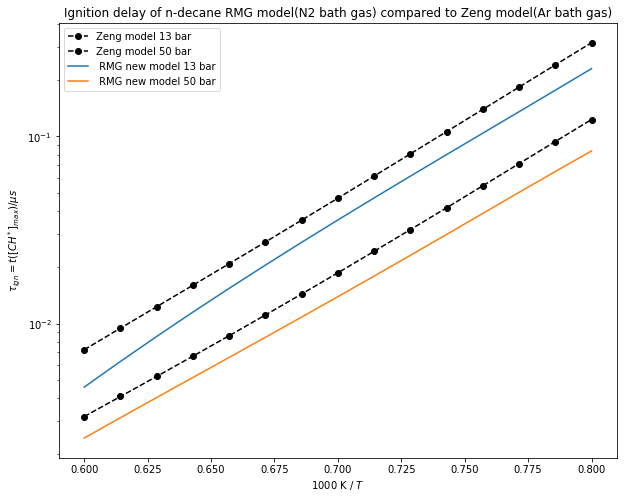

In [37]:
for key, val in Zeng_results.items():
    plt.semilogy(1000/RMG_temperatures_dkm, val, 'k--o', label= 'Zeng model {} bar'.format(key))
    


    
for P in pressures_bar:
    times = RMG_results[P]
    
    plt.semilogy(1000/RMG_temperatures_dkm,times,label=' RMG new model {} bar'.format(P))  
    
    
plt.legend(loc='best')
plt.xlabel('1000 K / $T$')
plt.ylabel('$\\tau_{ign} = t([CH^*]_{max})/\mu s$')
plt.rcParams['figure.figsize'] = [10, 8]
plt.title('Ignition delay of n-decane RMG model(N2 bath gas) compared to Zeng model(Ar bath gas)')
plt.show    